/home/sarim.hashmi/Downloads/RAG_basic_project/rag/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/sarim.hashmi/Downloads/RAG_basic_project/rag/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/sarim.hashmi/Downloads/RAG_basic_project/rag/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depract


 Did new product launches contribute to revenue growth in the fiscal year?

 

 Was an increase in pricing the main factor in the growth in revenue?

 

 How much did market share expansion play a role in boosting company revenues?

 

 What portion of the growth is attributable to strong international demand and presence?

 

 Was increased volume the biggest driving factor of company revenues increase during year period.
Query: What details can you provide about the factors that led to revenue growth?

Results:
revenue, classified by significant product and service offerings, was as follows :

research and development $ 27, 195 $ 24, 512 11 % as a percent of revenue 13 % 12 % 1pp
t ( in millions, except percentages ) 20232022percentage change sales and marketing $ 2
2, 759 $ 21, 825 4 % as a percent of revenue 11 % 11 % 0ppt ( in millions, except perce
ntages ) 20232022percentage change general and administrative $ 7, 575 $ 5, 900 28 % as
 a percent of revenue 4 % 3 % 1ppt 35

segme

/home/sarim.hashmi/Downloads/RAG_basic_project/rag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sarim.hashmi/Downloads/RAG_basic_project/rag/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


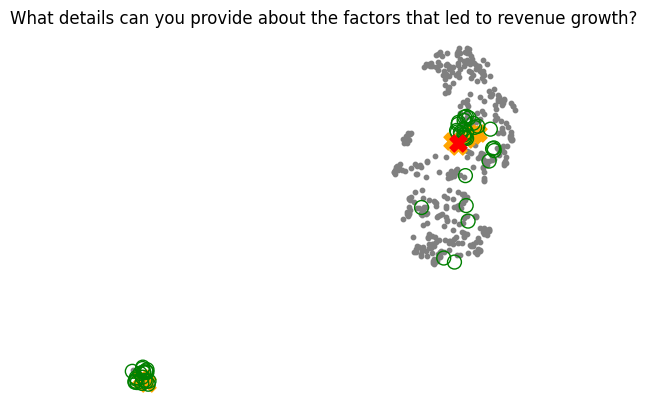

In [1]:
from utils.helper_utils import project_embeddings , word_wrap
from pypdf import PdfReader
import os
# from openai import OpenAI
from dotenv import load_dotenv
from groq import Groq
import chromadb
from chromadb.utils import embedding_functions
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from sentence_transformers import SentenceTransformer
from pypdf import PdfReader
import umap

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

client = Groq(api_key=groq_api_key)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
reader = PdfReader("asset/microsoft-annual-report.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

pdf_texts = [text for text in pdf_texts if text]

from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)


embedding_function = SentenceTransformerEmbeddingFunction()
# print(embedding_function([token_split_texts[10]]))

chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection(
    "microsoft-collection", embedding_function=embedding_function
)

# extract the embeddings of the token_split_texts
ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()
query = "What was the total revenue for the year?"


results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

def generate_multi_query(query, model="gpt-3.5-turbo"):

    prompt = """
    You are a knowledgeable financial research assistant. 
    Your users are inquiring about an annual report. 
    For the given question, propose up to five related questions to assist them in finding the information they need. 
    Provide concise, single-topic questions (withouth compounding sentences) that cover various aspects of the topic. 
    Ensure each question is complete and directly related to the original inquiry. 
    List each question on a separate line without numbering.
                """

    response = client.chat.completions.create(
        model="llama-3.1-70b-versatile",
        messages=[
            {
                "role": "system",
                "content": prompt,
            },
            {
                "role": "user",
                "content": query,
            },
        ],
    )

    


    content = response.choices[0].message.content
    content = content.split("\n")
    return content

original_query = (
    "What details can you provide about the factors that led to revenue growth?"
)
aug_queries = generate_multi_query(original_query)

# 1. First step show the augmented queries
for query in aug_queries:
    print("\n", query)

# 2. concatenate the original query with the augmented queries
joint_query = [
    original_query
] + aug_queries  # original query is in a list because chroma can actually handle multiple queries, so we add it in a list

# print("======> \n\n", joint_query)

results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)


# output the results documents
for i, documents in enumerate(retrieved_documents):
    print(f"Query: {joint_query[i]}")
    print("")
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print("")
    print("-" * 100)

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

# 4. We can also visualize the results in the embedding space
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(joint_query)


project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(
    augmented_query_embeddings, umap_transform
)

retrieved_embeddings = results["embeddings"]
result_embeddings = [item for sublist in retrieved_embeddings for item in sublist]

projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

import matplotlib.pyplot as plt


# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    project_augmented_queries[:, 0],
    project_augmented_queries[:, 1],
    s=150,
    marker="X",
    color="orange",
)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    project_original_query[:, 0],
    project_original_query[:, 1],
    s=150,
    marker="X",
    color="r",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot